In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import GPy
from matplotlib.colors import TwoSlopeNorm
from GPy.util.multioutput import ICM


In [26]:
def outcome_model(x, a, sd=1):
    """
    x: 1D array [x1, x2]
    a: 0 or 1 (control vs treatment)
    sd: noise standard deviation
    Returns: scalar outcome
    """
    x1, x2 = x
    base = (3/4)*np.exp(-((9*x1-2)**2)/4 -((9*x2-2)**2)/4) \
         + (3/4)*np.exp(-((9*x1+1)**2)/49 -((9*x2+1)**2)/10)
    treat_effect = (1/2)*a*np.exp(-((9*x1-7)**2)/4 -((9*x2-3)**2)/4) \
                  - (1/5)*a*np.exp(-((9*x1-4)**2) -((9*x2-7)**2))
    noise = np.random.normal(0, sd)
    return base + treat_effect + noise

def covariate_model(n):
    """Generate n covariates in [0,1]^2."""
    return np.random.uniform(0, 1, (n, 2))

def evaluate_performance(est, true):
    """
    Computes bias and RMSE.
    """
    bias = np.mean(est - true)
    rmse = np.sqrt(np.mean((est - true)**2))
    return bias, rmse

def plot_heatmap_single(data, title, X1, X2):
    """
    Plot a single heatmap of data.
    data: 2D array shaped as X1, X2
    X1, X2: meshgrid arrays
    """
    plt.figure(figsize=(6,5))
    levels = 25
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    vmin, vmax = data.min(), data.max()
    vcenter = 0.5*(vmin+vmax)
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    c = plt.contourf(X1, X2, data, levels=levels, cmap=cmap, norm=norm)
    plt.colorbar(c, label="Value")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_heatmaps_side_by_side(data1, title1, data2, title2, X1, X2):
    """
    Plot two contourf heatmaps side by side for comparison.
    data1, data2: 2D arrays of shape (n, n) matching X1, X2 shape
    X1, X2: meshgrid arrays for contour plotting
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    levels = 25
    cmap = sns.color_palette("coolwarm", as_cmap=True)

    vmin = min(data1.min(), data2.min())
    vmax = max(data1.max(), data2.max())
    vcenter = 0.5 * (vmin + vmax)
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    c1 = axes[0].contourf(X1, X2, data1, levels=levels, cmap=cmap, norm=norm)
    fig.colorbar(c1, ax=axes[0], label="Value")
    axes[0].set_xlabel("X1")
    axes[0].set_ylabel("X2")
    axes[0].set_title(title1)

    c2 = axes[1].contourf(X1, X2, data2, levels=levels, cmap=cmap, norm=norm)
    fig.colorbar(c2, ax=axes[1], label="Value")
    axes[1].set_xlabel("X1")
    axes[1].set_ylabel("X2")
    axes[1].set_title(title2)

    plt.tight_layout()
    plt.show()


In [27]:

n_grid = 50
x = np.linspace(0, 1, n_grid)
X1, X2 = np.meshgrid(x, x)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

X_grid.shape

(2500, 2)

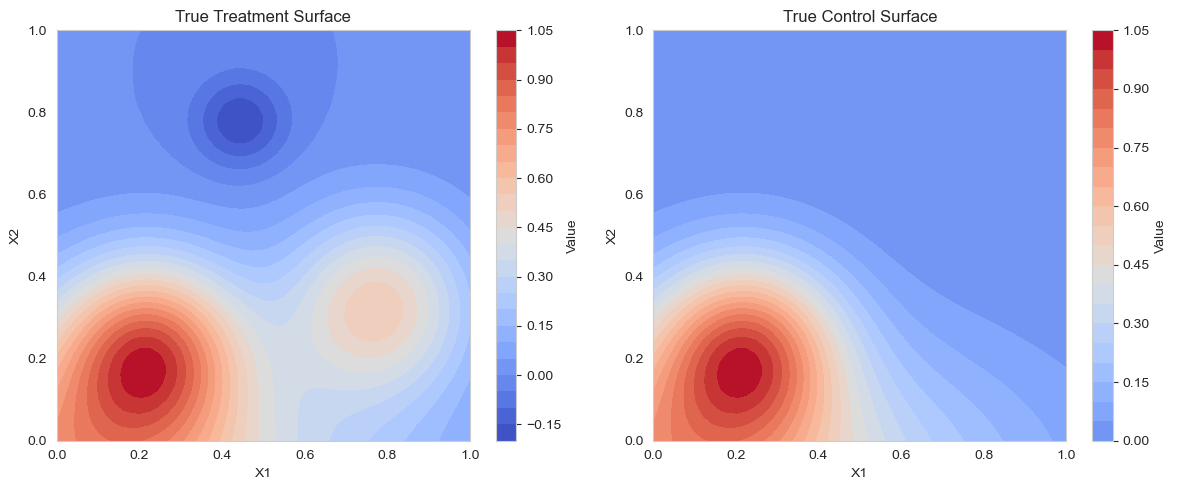

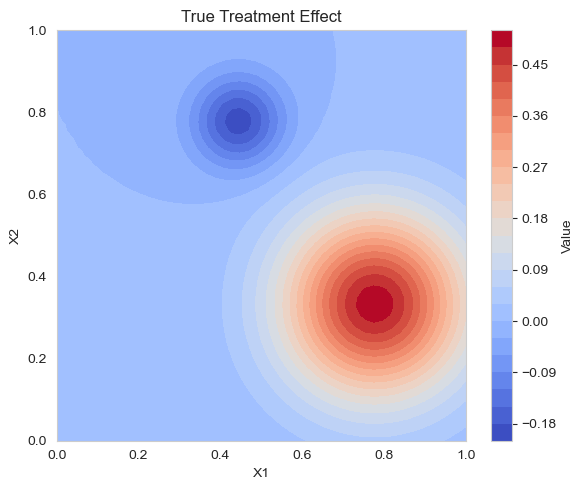

In [28]:

# True Potential Outcomes
Y_treatment_true = np.array([outcome_model(xi, 1, sd=0) for xi in X_grid])
Y_control_true = np.array([outcome_model(xi, 0, sd=0) for xi in X_grid])
TE_true = Y_treatment_true - Y_control_true

Y_treatment_true_reshaped = Y_treatment_true.reshape(X1.shape)
Y_control_true_reshaped = Y_control_true.reshape(X1.shape)
TE_true_reshaped = TE_true.reshape(X1.shape)

plot_heatmaps_side_by_side(Y_treatment_true_reshaped, "True Treatment Surface",
                           Y_control_true_reshaped, "True Control Surface",
                           X1, X2)

plot_heatmap_single(TE_true_reshaped, "True Treatment Effect", X1, X2)


In [29]:

# Observed data
n_train = 300
X_train = covariate_model(n_train)
A_train = np.random.binomial(1, 0.5, size=n_train)
Y_train = np.array([outcome_model(xi, ai, sd=0.1) for xi, ai in zip(X_train, A_train)])

X_control = X_train[A_train == 0]
Y_control = Y_train[A_train == 0].reshape(-1, 1)

X_treatment = X_train[A_train == 1]
Y_treatment = Y_train[A_train == 1].reshape(-1, 1)

def fit_multioutput_gp(X_list, Y_list):
    X_with_output_list = []
    for i, (X_part, Y_part) in enumerate(zip(X_list, Y_list)):
        out_idx = np.full((X_part.shape[0], 1), i, dtype=int)
        X_with_output = np.hstack([X_part, out_idx])
        X_with_output_list.append(X_with_output)
        
    # base_kernel = GPy.kern.RBF(input_dim=2, variance=1.0, lengthscale=1.0)
    # # Coregionalize expects input_dim=1 since it's indexing outputs
    # coreg = GPy.kern.Coregionalize(input_dim=1, output_dim=len(X_list), rank=rank)
    # multi_kern = base_kernel * coreg

    # model = GPy.models.GPCoregionalizedRegression(X_with_output_list, Y_list, kernel=multi_kern)
    # model.optimize(messages=False, max_f_eval=1000)
    
    # ICM kernel for correct handling of multi-output
    num_outputs = len(X_list)
    rbf = GPy.kern.RBF(input_dim=2, variance=1.0, lengthscale=1.0)
    icm = ICM(input_dim=2, num_outputs=num_outputs, kernel=rbf, W_rank=1)

    model = GPy.models.GPCoregionalizedRegression(X_with_output_list, Y_list, kernel=icm)
    model.optimize(messages=False, max_f_eval=1000)
    return model

model = fit_multioutput_gp([X_control, X_treatment], [Y_control, Y_treatment])

def predict_multioutput_gp(model, X_test):
    # Control predictions
    X_test_control = np.hstack([X_test, np.zeros((X_test.shape[0], 1), dtype=int)])
    pred_control = model.predict(X_test_control, Y_metadata={'output_index': np.zeros((X_test_control.shape[0],1),dtype=int)})

    # Treatment predictions
    X_test_treatment = np.hstack([X_test, np.ones((X_test.shape[0], 1), dtype=int)])
    pred_treatment = model.predict(X_test_treatment, Y_metadata={'output_index': np.ones((X_test_treatment.shape[0],1),dtype=int)})
    return pred_control, pred_treatment


 /Users/sudhamshu.hosamane/opt/anaconda3/envs/DoE_prj/lib/python3.10/site-packages/GPy/core/gp.py:85: UserWarning:Your kernel has a different input dimension 3 then the given X dimension 4. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


In [30]:
pred_control, pred_treatment = predict_multioutput_gp(model, X_grid)
Y_control_pred = pred_control[0].flatten()
Y_treatment_pred = pred_treatment[0].flatten()

TE_pred = Y_treatment_pred - Y_control_pred

Y_control_pred_reshaped = Y_control_pred.reshape(X1.shape)
Y_treatment_pred_reshaped = Y_treatment_pred.reshape(X1.shape)
TE_pred_reshaped = TE_pred.reshape(X1.shape)

In [31]:
TE_pred_reshaped

array([[-0.01302204, -0.01813278, -0.02314605, ...,  0.03904434,
         0.03480668,  0.03026982],
       [-0.0132349 , -0.01789959, -0.02246214, ...,  0.05447853,
         0.04930823,  0.04376386],
       [-0.01332106, -0.01743911, -0.0214474 , ...,  0.07198019,
         0.06577805,  0.05911996],
       ...,
       [-0.03444419, -0.02991272, -0.02535402, ..., -0.02926142,
        -0.03634189, -0.04256862],
       [-0.03674369, -0.03201717, -0.02720164, ..., -0.03002709,
        -0.03702817, -0.04314518],
       [-0.03925188, -0.03436539, -0.0293269 , ..., -0.03079329,
        -0.03766406, -0.04362859]])

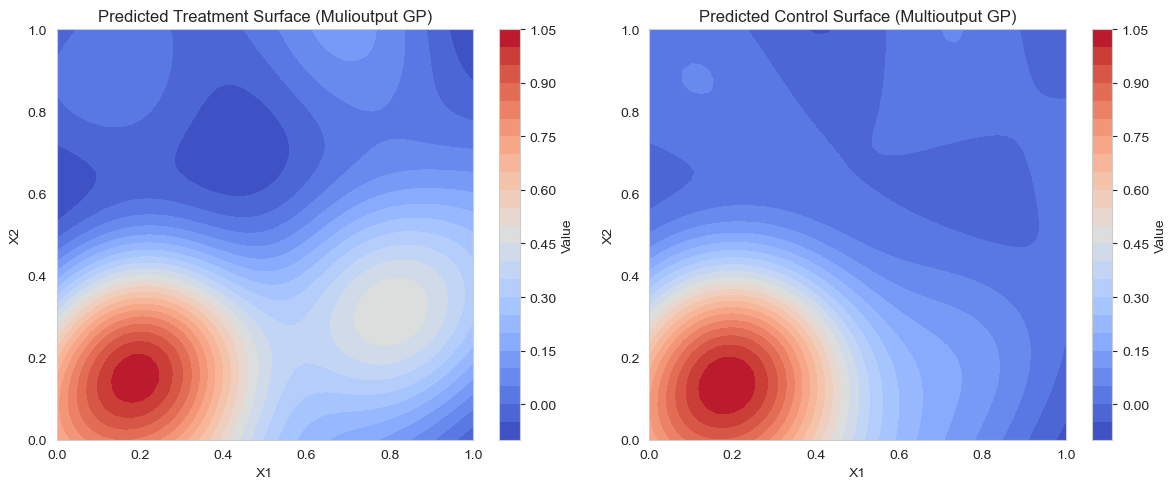

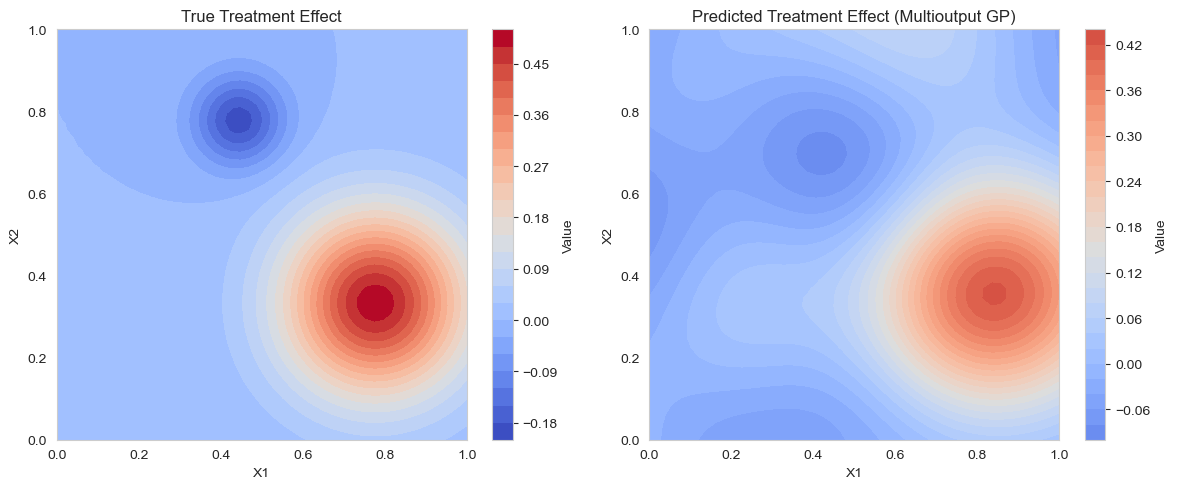

Treatment Effect - Bias: -0.0044, RMSE: 0.0466


In [32]:

plot_heatmaps_side_by_side(Y_treatment_pred_reshaped, "Predicted Treatment Surface (Mulioutput GP)",
                           Y_control_pred_reshaped, "Predicted Control Surface (Multioutput GP)",
                           X1, X2)

plot_heatmaps_side_by_side(TE_true_reshaped, "True Treatment Effect",
                           TE_pred_reshaped, "Predicted Treatment Effect (Multioutput GP)",
                           X1, X2)


bias_TE, rmse_TE = evaluate_performance(TE_pred, TE_true)
print(f"Treatment Effect - Bias: {bias_TE:.4f}, RMSE: {rmse_TE:.4f}")


In [33]:
n_repetitions = 50
bias_list = []
rmse_list = []

for i in range(n_repetitions):
    # Generate Training Data
    X_train = covariate_model(n_train)
    A_train = np.random.binomial(1, 0.5, size=n_train)  # Random treatment assignment
    Y_train = np.array([outcome_model(xi, ai, sd=0.1) for xi, ai in zip(X_train, A_train)])
    
    X_control = X_train[A_train == 0]
    Y_control = Y_train[A_train == 0].reshape(-1, 1)
    
    X_treatment = X_train[A_train == 1]
    Y_treatment = Y_train[A_train == 1].reshape(-1, 1)
    
    # Fit the multi-output GP model
    try:
        model = fit_multioutput_gp([X_control, X_treatment], [Y_control, Y_treatment])
    except Exception as e:
        print(f"Repetition {i+1}: Model fitting failed with error: {e}")
        continue  # Skip to the next iteration if fitting fails
    
    # Predict on Grid
    pred_control, pred_treatment = predict_multioutput_gp(model, X_grid)
    Y_control_pred = pred_control[0].flatten()
    Y_treatment_pred = pred_treatment[0].flatten()
    
    TE_pred = Y_treatment_pred - Y_control_pred
    
    # Compute bias and RMSE
    bias, rmse = evaluate_performance(TE_pred, TE_true)
    bias_list.append(bias)
    rmse_list.append(rmse)
    
    print(f"Repetition {i+1}/{n_repetitions} - Bias: {bias:.4f}, RMSE: {rmse:.4f}")

# Calculate average and standard deviation
average_bias = np.mean(bias_list)
std_bias = np.std(bias_list)
average_rmse = np.mean(rmse_list)
std_rmse = np.std(rmse_list)

print(f"\nAfter {n_repetitions} repetitions:")
print(f"Average Bias: {average_bias:.4f} ± {std_bias:.4f}")
print(f"Average RMSE: {average_rmse:.4f} ± {std_rmse:.4f}")


Repetition 1/50 - Bias: 0.0240, RMSE: 0.0467
Repetition 2/50 - Bias: 0.0084, RMSE: 0.0381
Repetition 3/50 - Bias: 0.0070, RMSE: 0.0603
Repetition 4/50 - Bias: 0.0130, RMSE: 0.0523
Repetition 5/50 - Bias: 0.0050, RMSE: 0.0426
Repetition 6/50 - Bias: -0.0195, RMSE: 0.0470
Repetition 7/50 - Bias: 0.0227, RMSE: 0.0472
Repetition 8/50 - Bias: 0.0024, RMSE: 0.0458
Repetition 9/50 - Bias: -0.0057, RMSE: 0.0530
Repetition 10/50 - Bias: -0.0107, RMSE: 0.0479
Repetition 11/50 - Bias: 0.0223, RMSE: 0.0643
Repetition 12/50 - Bias: 0.0199, RMSE: 0.0516
Repetition 13/50 - Bias: 0.0007, RMSE: 0.0538
Repetition 14/50 - Bias: -0.0147, RMSE: 0.0579
Repetition 15/50 - Bias: 0.0063, RMSE: 0.0429
Repetition 16/50 - Bias: 0.0089, RMSE: 0.0570
Repetition 17/50 - Bias: 0.0020, RMSE: 0.0610
Repetition 18/50 - Bias: 0.0077, RMSE: 0.0516
Repetition 19/50 - Bias: 0.0034, RMSE: 0.0539
Repetition 20/50 - Bias: 0.0036, RMSE: 0.0494
Repetition 21/50 - Bias: -0.0012, RMSE: 0.0471
Repetition 22/50 - Bias: 0.0125, RMSE:

True ATE: 0.05140915840952811
Random assignment:
 Bias: -0.0247, MSE: 0.0084
VR assignment:
 Bias: 0.0145, MSE: 0.0195


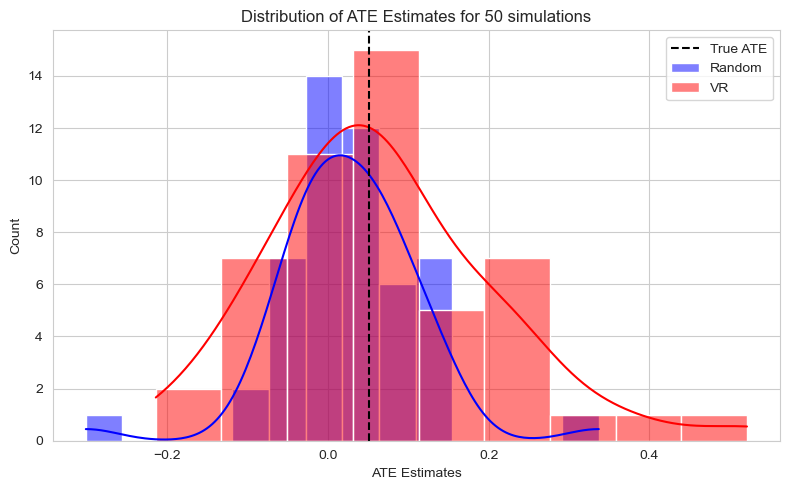

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import GPy
from matplotlib.colors import TwoSlopeNorm
from GPy.util.multioutput import ICM

sns.set_style("whitegrid")


def outcome_model(x, a, sd=0.1):
    x1, x2 = x
    base = (3/4)*np.exp(-((9*x1-2)**2)/4 -((9*x2-2)**2)/4) \
         + (3/4)*np.exp(-((9*x1+1)**2)/49 -((9*x2+1)**2)/10)
    treat_effect = (1/2)*a*np.exp(-((9*x1-7)**2)/4 -((9*x2-3)**2)/4) \
                  - (1/5)*a*np.exp(-((9*x1-4)**2) -((9*x2-7)**2))
    noise = np.random.normal(0, sd)
    return base + treat_effect + noise

def covariate_model(n):
    return np.random.uniform(0, 1, (n, 2))

def evaluate_performance(est, true):
    bias = np.mean(est - true)
    mse = np.mean((est - true)**2)
    return bias, mse

# Fit and predict with multi-output GP using ICM as in corrected code
def fit_multioutput_gp(X_list, Y_list):
    X_with_output_list = []
    for i, (X_part, Y_part) in enumerate(zip(X_list, Y_list)):
        out_idx = np.full((X_part.shape[0], 1), i, dtype=int)
        X_with_output = np.hstack([X_part, out_idx])
        X_with_output_list.append(X_with_output)
    
    num_outputs = len(X_list)
    rbf = GPy.kern.RBF(input_dim=2, variance=1.0, lengthscale=1.0)
    icm = ICM(input_dim=2, num_outputs=num_outputs, kernel=rbf, W_rank=1)
    model = GPy.models.GPCoregionalizedRegression(X_with_output_list, Y_list, kernel=icm)
    model.optimize(messages=False, max_f_eval=1000)
    return model

def predict_multioutput_gp(model, X_test):
    X_test_control = np.hstack([X_test, np.zeros((X_test.shape[0],1), dtype=int)])
    pred_control = model.predict(X_test_control, Y_metadata={'output_index': np.zeros((X_test_control.shape[0],1),dtype=int)})

    X_test_treatment = np.hstack([X_test, np.ones((X_test.shape[0],1), dtype=int)])
    pred_treatment = model.predict(X_test_treatment, Y_metadata={'output_index': np.ones((X_test_treatment.shape[0],1),dtype=int)})

    return pred_control, pred_treatment

def approximate_ate_variance(model, X_test):
    # Approximate variance of ATE by sum of predictive variances as a proxy
    pred_c, pred_t = predict_multioutput_gp(model, X_test)
    var_c = pred_c[1].flatten()
    var_t = pred_t[1].flatten()
    var_approx = np.mean(var_c + var_t)
    return var_approx

def compute_variance_reduction(X_c, Y_c, X_t, Y_t, x_next, a_next, X_test):
    # Compute old var
    model_old = fit_multioutput_gp([X_c, X_t],[Y_c,Y_t])
    old_var = approximate_ate_variance(model_old, X_test)

    # Add new point with chosen arm a_next
    y_next = outcome_model(x_next[0], a_next)
    if a_next == 0:
        X_c_new = np.vstack([X_c, x_next])
        Y_c_new = np.vstack([Y_c, [[y_next]]])
        X_t_new = X_t
        Y_t_new = Y_t
    else:
        X_c_new = X_c
        Y_c_new = Y_c
        X_t_new = np.vstack([X_t, x_next])
        Y_t_new = np.vstack([Y_t, [[y_next]]])
    
    model_new = fit_multioutput_gp([X_c_new, X_t_new],[Y_c_new,Y_t_new])
    new_var = approximate_ate_variance(model_new, X_test)
    return old_var - new_var


# Scenario 1: Random Assignment
def simulation_random(B, n_train, covariate_model, outcome_model, X_test, ATE_true):
    ATE_estimates = []
    for b in range(B):
        X_train = covariate_model(n_train)
        A_train = np.random.binomial(1,0.5,size=n_train)
        Y_train = np.array([outcome_model(Xi, Ai) for Xi, Ai in zip(X_train, A_train)])
        
        X_c = X_train[A_train==0]; Y_c = Y_train[A_train==0].reshape(-1,1)
        X_t = X_train[A_train==1]; Y_t = Y_train[A_train==1].reshape(-1,1)
        
        model = fit_multioutput_gp([X_c, X_t],[Y_c,Y_t])
        pred_c, pred_t = predict_multioutput_gp(model, X_test)
        ATE_est = np.mean(pred_t[0].flatten() - pred_c[0].flatten())
        ATE_estimates.append(ATE_est)
    bias, mse = evaluate_performance(np.array(ATE_estimates), ATE_true)
    return ATE_estimates, bias, mse

# ------------------------------
# Scenario 1: Variance Reduction Assignment
# ------------------------------
def simulation_VR(B, n_train, n_init, covariate_model, outcome_model, X_test, ATE_true):
    ATE_estimates = []
    for b in range(B):
        X_pool = covariate_model(n_train)
        idx_init = np.random.choice(n_train, n_init, replace=False)
        A_init = np.random.binomial(1,0.5,size=n_init)
        Y_init = np.array([outcome_model(Xi, Ai) for Xi,Ai in zip(X_pool[idx_init],A_init)])
        
        X_c = X_pool[idx_init][A_init==0]; Y_c = Y_init[A_init==0].reshape(-1,1)
        X_t = X_pool[idx_init][A_init==1]; Y_t = Y_init[A_init==1].reshape(-1,1)
        
        assigned_idx = set(idx_init)
        remaining = list(set(range(n_train)) - assigned_idx)
        
        for next_i in remaining:
            x_next = X_pool[next_i:next_i+1]
            vr_c = compute_variance_reduction(X_c,Y_c,X_t,Y_t,x_next,0,X_test)
            vr_t = compute_variance_reduction(X_c,Y_c,X_t,Y_t,x_next,1,X_test)
            
            if vr_c >= vr_t:
                a_next = 0
            else:
                a_next = 1
            
            y_next = outcome_model(x_next[0], a_next)
            if a_next == 0:
                X_c = np.vstack([X_c, x_next])
                Y_c = np.vstack([Y_c, [[y_next]]])
            else:
                X_t = np.vstack([X_t, x_next])
                Y_t = np.vstack([Y_t, [[y_next]]])
            
            assigned_idx.add(next_i)
        
        model_final = fit_multioutput_gp([X_c,X_t],[Y_c,Y_t])
        pred_c_final, pred_t_final = predict_multioutput_gp(model_final, X_test)
        ATE_est = np.mean(pred_t_final[0].flatten() - pred_c_final[0].flatten())
        ATE_estimates.append(ATE_est)
    bias, mse = evaluate_performance(np.array(ATE_estimates), ATE_true)
    return ATE_estimates, bias, mse

# ------------------------------
# Demo Execution
# ------------------------------
if __name__ == "__main__":
    # Test set and true ATE
    n_test = 50
    X_test = covariate_model(n_test)
    true_treatment = np.array([outcome_model(x,1,sd=0) for x in X_test])
    true_control = np.array([outcome_model(x,0,sd=0) for x in X_test])
    ATE_true = np.mean(true_treatment - true_control)
    
    B = 50     
    n_train = 30
    n_init = 5
    
    ATE_random_est, bias_random, mse_random = simulation_random(B, n_train, covariate_model, outcome_model, X_test, ATE_true)
    ATE_VR_est, bias_VR, mse_VR = simulation_VR(B, n_train, n_init, covariate_model, outcome_model, X_test, ATE_true)
    
    print("True ATE:", ATE_true)
    print("Random assignment:")
    print(f" Bias: {bias_random:.4f}, MSE: {mse_random:.4f}")
    print("VR assignment:")
    print(f" Bias: {bias_VR:.4f}, MSE: {mse_VR:.4f}")
    
    # Plot distributions
    plt.figure(figsize=(8,5))
    sns.histplot(ATE_random_est, color='blue', label='Random', kde=True)
    sns.histplot(ATE_VR_est, color='red', label='VR', kde=True)
    plt.axvline(ATE_true, color='black', linestyle='--', label='True ATE')
    plt.title("Distribution of ATE Estimates for 50 simulations")
    plt.xlabel("ATE Estimates")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


 /Users/sudhamshu.hosamane/opt/anaconda3/envs/DoE_prj/lib/python3.10/site-packages/GPy/core/gp.py:85: UserWarning:Your kernel has a different input dimension 3 then the given X dimension 4. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel
 /Users/sudhamshu.hosamane/opt/anaconda3/envs/DoE_prj/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


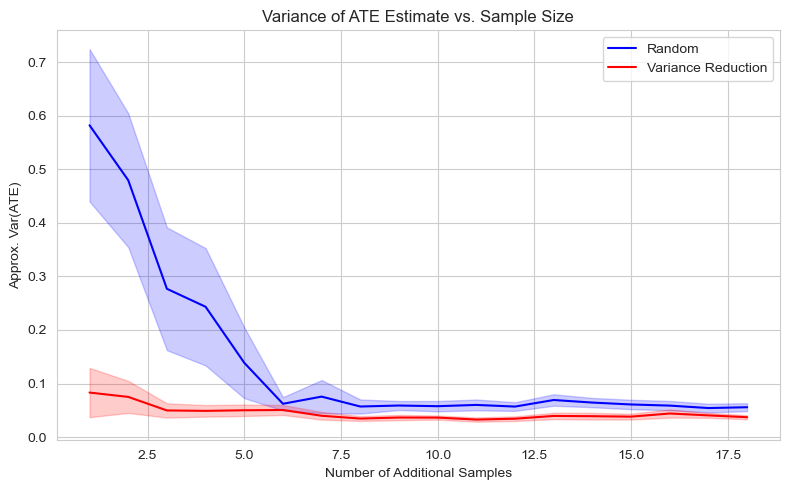

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import GPy
from GPy.util.multioutput import ICM

sns.set_style("whitegrid")

def outcome_model(x, a, sd=0.1):
    x1, x2 = x
    base = (3/4)*np.exp(-((9*x1-2)**2)/4 - ((9*x2-2)**2)/4) \
         + (3/4)*np.exp(-((9*x1+1)**2)/49 - ((9*x2+1)**2)/10)
    treat_effect = (1/2)*a*np.exp(-((9*x1-7)**2)/4 - ((9*x2-3)**2)/4) \
                  - (1/5)*a*np.exp(-((9*x1-4)**2) - ((9*x2-7)**2))
    noise = np.random.normal(0, sd)
    return base + treat_effect + noise

def covariate_model(n):
    return np.random.uniform(0, 1, (n, 2))

def fit_multioutput_gp(X_list, Y_list):
    X_with_output_list = []
    for i, (X_part, Y_part) in enumerate(zip(X_list, Y_list)):
        out_idx = np.full((X_part.shape[0], 1), i, dtype=int)
        X_with_output = np.hstack([X_part, out_idx])
        X_with_output_list.append(X_with_output)
    
    rbf = GPy.kern.RBF(input_dim=2, variance=1.0, lengthscale=1.0)
    icm = ICM(input_dim=2, num_outputs=len(X_list), kernel=rbf, W_rank=1)
    model = GPy.models.GPCoregionalizedRegression(X_with_output_list, Y_list, kernel=icm)
    model.optimize(messages=False, max_f_eval=1000)
    return model

def predict_multioutput_gp(model, X_test):
    X_test_control = np.hstack([X_test, np.zeros((X_test.shape[0],1), dtype=int)])
    pred_control = model.predict(X_test_control, Y_metadata={'output_index': np.zeros((X_test_control.shape[0],1),dtype=int)})

    X_test_treatment = np.hstack([X_test, np.ones((X_test.shape[0],1), dtype=int)])
    pred_treatment = model.predict(X_test_treatment, Y_metadata={'output_index': np.ones((X_test_treatment.shape[0],1),dtype=int)})

    return pred_control, pred_treatment

def approximate_ate_variance(model, X_test):
    pred_c, pred_t = predict_multioutput_gp(model, X_test)
    var_c = pred_c[1].flatten()
    var_t = pred_t[1].flatten()
    var_approx = np.mean(var_c + var_t)
    return var_approx

def add_observation(X_c, Y_c, X_t, Y_t, x_new, a_new):
    y_new = outcome_model(x_new[0], a_new)
    if a_new == 0:
        X_c_new = np.vstack([X_c, x_new])
        Y_c_new = np.vstack([Y_c, [[y_new]]])
        X_t_new = X_t
        Y_t_new = Y_t
    else:
        X_c_new = X_c
        Y_c_new = Y_c
        X_t_new = np.vstack([X_t, x_new])
        Y_t_new = np.vstack([Y_t, [[y_new]]])
    return X_c_new, Y_c_new, X_t_new, Y_t_new

def compute_variance_reduction(X_c, Y_c, X_t, Y_t, x_next, a_next, X_test):
    # Old var
    model_old = fit_multioutput_gp([X_c, X_t],[Y_c,Y_t])
    old_var = approximate_ate_variance(model_old, X_test)
    # Hypothetical new
    X_c_new, Y_c_new, X_t_new, Y_t_new = add_observation(X_c, Y_c, X_t, Y_t, x_next, a_next)
    model_new = fit_multioutput_gp([X_c_new, X_t_new],[Y_c_new,Y_t_new])
    new_var = approximate_ate_variance(model_new, X_test)
    return old_var - new_var

def simulate_random_incremental(n_train, covariate_model, outcome_model, X_test):
    # We do an incremental approach:
    # Initially no data, add units one by one
    # Actually we start with at least one point to avoid degenerate fitting
    X_pool = covariate_model(n_train)
    # Start with one point randomly assigned
    idx = [0]
    A_init = np.random.binomial(1,0.5)
    Y_init = outcome_model(X_pool[0], A_init)
    if A_init == 0:
        X_c = X_pool[0:1]; Y_c = np.array([[Y_init]])
        X_t = np.zeros((0,2)); Y_t = np.zeros((0,1))
    else:
        X_c = np.zeros((0,2)); Y_c = np.zeros((0,1))
        X_t = X_pool[0:1]; Y_t = np.array([[Y_init]])
    
    var_trace = []
    for i in range(1, n_train):
        # Assign randomly
        a_next = np.random.binomial(1,0.5)
        X_c, Y_c, X_t, Y_t = add_observation(X_c, Y_c, X_t, Y_t, X_pool[i:i+1], a_next)
        model = fit_multioutput_gp([X_c,X_t],[Y_c,Y_t])
        var_trace.append(approximate_ate_variance(model, X_test))
    return var_trace

def simulate_vr_incremental(n_train, n_init, covariate_model, outcome_model, X_test):
    X_pool = covariate_model(n_train)
    # Start with n_init random points
    idx_init = np.random.choice(n_train, n_init, replace=False)
    A_init = np.random.binomial(1,0.5,size=n_init)
    Y_init = [outcome_model(X_pool[i], A_init_j) for i,A_init_j in zip(idx_init,A_init)]
    X_c = X_pool[idx_init][A_init==0]
    Y_c = np.array(Y_init)[A_init==0].reshape(-1,1)
    X_t = X_pool[idx_init][A_init==1]
    Y_t = np.array(Y_init)[A_init==1].reshape(-1,1)

    assigned = set(idx_init)
    remaining = [i for i in range(n_train) if i not in assigned]
    
    var_trace = []
    for next_i in remaining:
        x_next = X_pool[next_i:next_i+1]
        vr_c = compute_variance_reduction(X_c,Y_c,X_t,Y_t,x_next,0,X_test)
        vr_t = compute_variance_reduction(X_c,Y_c,X_t,Y_t,x_next,1,X_test)
        if vr_c >= vr_t:
            a_next=0
        else:
            a_next=1
        X_c, Y_c, X_t, Y_t = add_observation(X_c, Y_c, X_t, Y_t, x_next, a_next)
        model = fit_multioutput_gp([X_c,X_t],[Y_c,Y_t])
        var_trace.append(approximate_ate_variance(model, X_test))
    return var_trace


# Main Demo (to Create a Plot)
if __name__ == "__main__":
    # Create a test set
    n_test = 50
    X_test = covariate_model(n_test)
    true_treatment = np.array([outcome_model(x,1,sd=0) for x in X_test])
    true_control = np.array([outcome_model(x,0,sd=0) for x in X_test])
    ATE_true = np.mean(true_treatment - true_control)

    B = 15          # Replications
    n_train = 20
    n_init = 2

    # We'll record the variance trace over increments
    # Note: The length of var_trace for VR vs random differs slightly because VR starts with n_init points
    # and random starts with 1 point. To align them, let's ensure both produce the same number of steps.
    # We'll have VR produce traces of length (n_train - n_init) and random produce traces of length (n_train - 1).
    # We'll just align on min steps for plotting.
    steps = n_train - max(n_init,1)

    var_traces_random = []
    var_traces_vr = []
    for b in range(B):
        var_trace_rand = simulate_random_incremental(n_train, covariate_model, outcome_model, X_test)
        var_trace_vr = simulate_vr_incremental(n_train, n_init, covariate_model, outcome_model, X_test)
        # Truncate to min length
        min_len = min(len(var_trace_rand), len(var_trace_vr))
        var_traces_random.append(var_trace_rand[:min_len])
        var_traces_vr.append(var_trace_vr[:min_len])

    var_traces_random = np.array(var_traces_random)
    var_traces_vr = np.array(var_traces_vr)

    mean_rand = var_traces_random.mean(axis=0)
    se_rand = var_traces_random.std(axis=0)/np.sqrt(B)

    mean_vr = var_traces_vr.mean(axis=0)
    se_vr = var_traces_vr.std(axis=0)/np.sqrt(B)

    # Plot the line plot of var(ATE) over iterations
    plt.figure(figsize=(8,5))
    iterations = np.arange(1, len(mean_rand)+1)
    plt.plot(iterations, mean_rand, label='Random', color='blue')
    plt.fill_between(iterations, mean_rand-se_rand, mean_rand+se_rand, color='blue', alpha=0.2)
    plt.plot(iterations, mean_vr, label='Variance Reduction', color='red')
    plt.fill_between(iterations, mean_vr-se_vr, mean_vr+se_vr, color='red', alpha=0.2)

    plt.xlabel("Number of Additional Samples")
    plt.ylabel("Approx. Var(ATE)")
    plt.title("Variance of ATE Estimate vs. Sample Size")
    plt.legend()
    plt.tight_layout()
    plt.show()
